### Pip Install

In [28]:
!pip install Sastrawi
!pip install tqdm
!pip install swifter
!pip install dask[dataframe]

  Using cached Sastrawi-1.0.1-py2.py3-none-any.whl.metadata (909 bytes)
Using cached Sastrawi-1.0.1-py2.py3-none-any.whl (209 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached swifter-1.4.0.tar.gz (1.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached dask-2025.5.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached partd-1.4.2-py3-none-any.whl.metadata (4.6 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_metadata-8.7.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached zipp-3.23.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached locket-1.0.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached da

  DEPRECATION: Building 'swifter' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'swifter'. Discussion can be found at https://github.com/pypa/pip/issues/6334


### Import Library

In [29]:
import pandas as pd
import numpy as np
import gc
import time
import swifter
import re #For Regex
import Sastrawi
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
tqdm.pandas()

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

### Dataset Awal: df

In [30]:
df = pd.read_csv('Downloads/politik_merge.csv')
df.head()

,Judul,Waktu,Link,Content,tag1,tag2,tag3,tag4,tag5,source
0,Jokowi Kenakan Pakaian Adat Betawi di Sidang T...,16/08/2024,https://nasional.kompas.com/read/2024/08/16/11...,"JAKARTA, KOMPAS.com - Presiden Joko Widodo me...",Presiden Jokowi,Jokowi,sidang tahunan MPR RI 2024,Jokowi adat Betawi sidang mpr 2024,Megawati tak hadiri sidang tahunan MPR 2024,kompas
1,Amnesty International Beberkan 6 Indikator Kri...,2024-07-18,https://nasional.tempo.co/read/1893144/amnesty...,"TEMPO.CO, Jakarta - Amnesty International Indo...",Amnesty International,Amnesty International Indonesia,Kebebasan Berpendapat,Indeks Demokrasi,Revisi UU TNI,tempo
2,"Jelang Long Weekend, Stasiun Kereta Cepat Hali...","Rabu, 08 Mei 2024 19:18 WIB",https://news.detik.com/berita/d-7331666/jelang...,"Stasiun kereta cepat Whoosh di Halim, Jakarta ...",kereta cepat whoosh,stasiun halim,long weekend,NaN,NaN,detik
3,KPU Tegaskan Pemilih Tak Terdaftar di DPT Bisa...,13/02/2024,https://nasional.kompas.com/read/2024/02/13/21...,"JAKARTA, KOMPAS.com - Komisi Pemilihan Umum (...",KPU,pemilu 2024,Hasyim Asy'ari,NaN,NaN,kompas
4,Kemenag Luncurkan Gerakan Senam Haji Jaga Keta...,2024-04-29,https://nasional.tempo.co/read/1861810/kemenag...,"TEMPO.CO, Jakarta - Kementerian Agama atau Kem...",Senam Haji,Kemenag,Jemaah Haji,Ibadah Haji,Asrama Haji,tempo


In [32]:
#Cek data duplikat lewat link berita
print('Data Duplikat:',df['Link'].duplicated().any())
print('Total:', df['Link'].duplicated().sum(),'\n')

#Cek data kosong
print('Data Kosong:',df[['Content', 'Judul']].isnull().values.any())
print('Total:\n',df[['Content', 'Judul']].isnull().sum())

Data Duplikat: True
Total: 434 

Data Kosong: True
Total:
 Content    39
Judul      35
dtype: int64


In [31]:
value_counts = df['source'].value_counts()
print(value_counts)

source
detik     17770
tempo     17229
kompas    10710
Name: count, dtype: int64


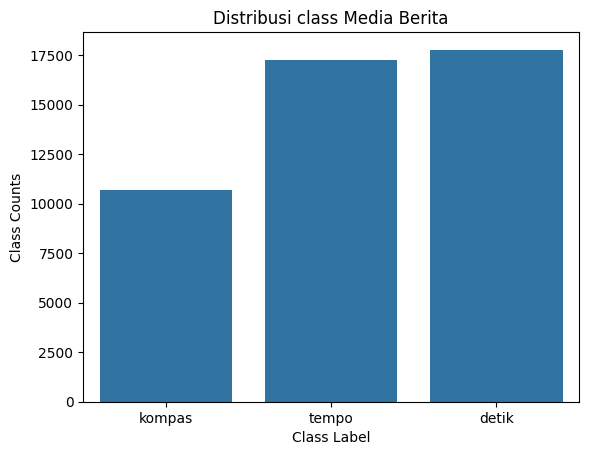

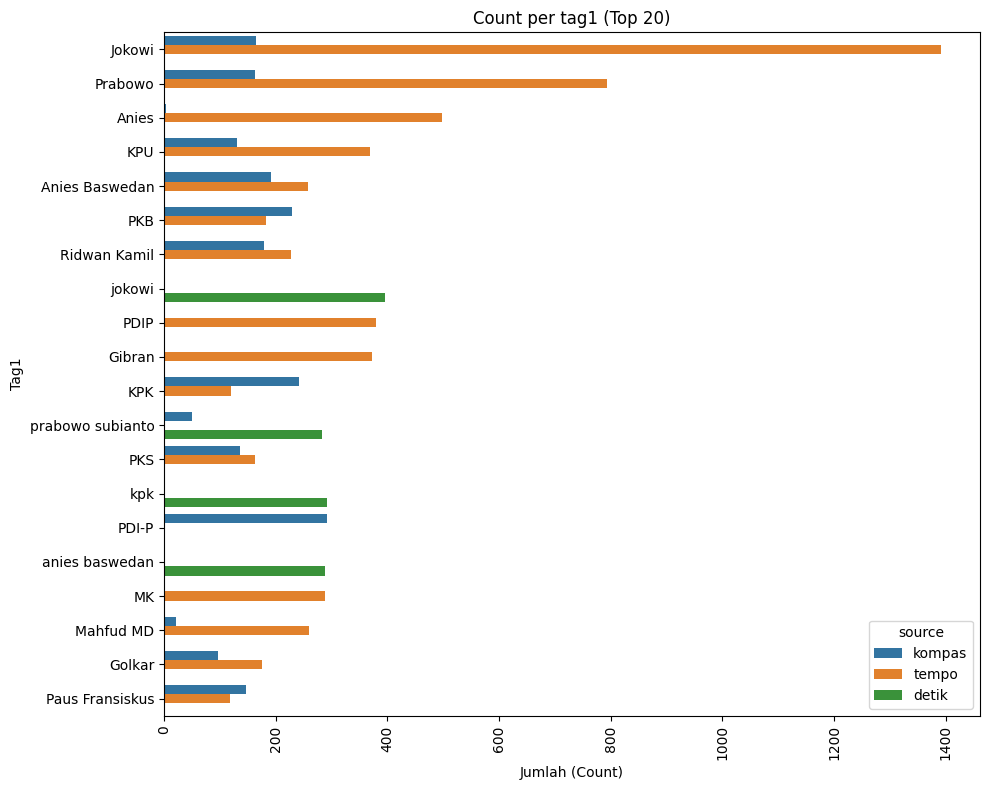

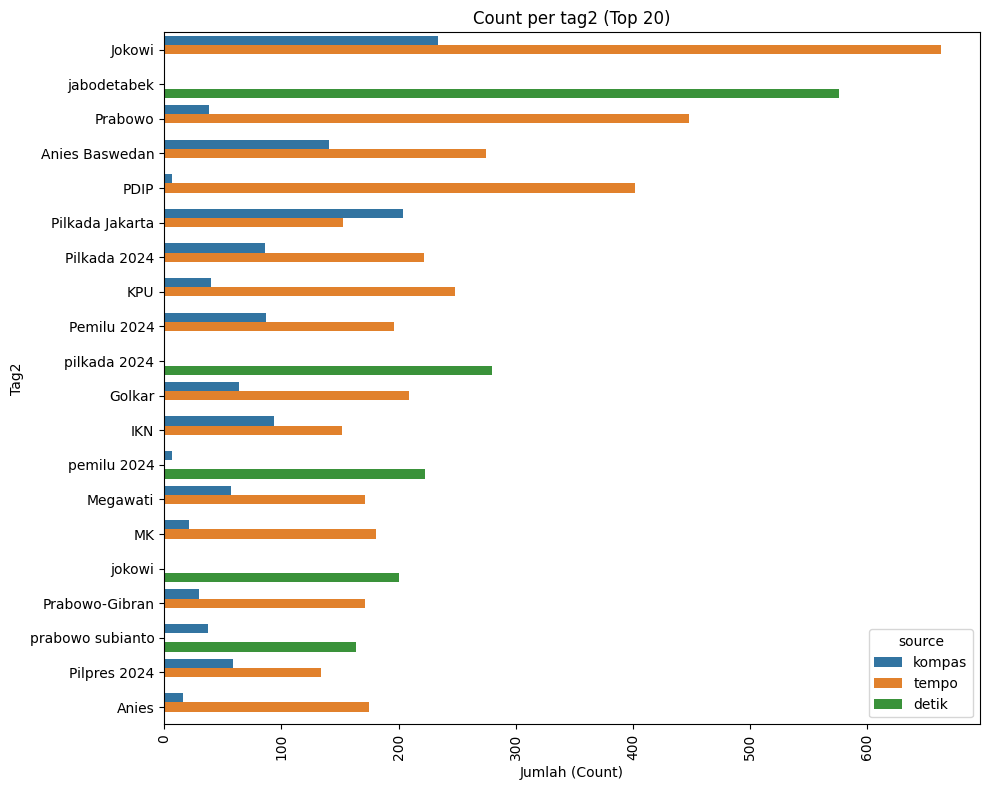

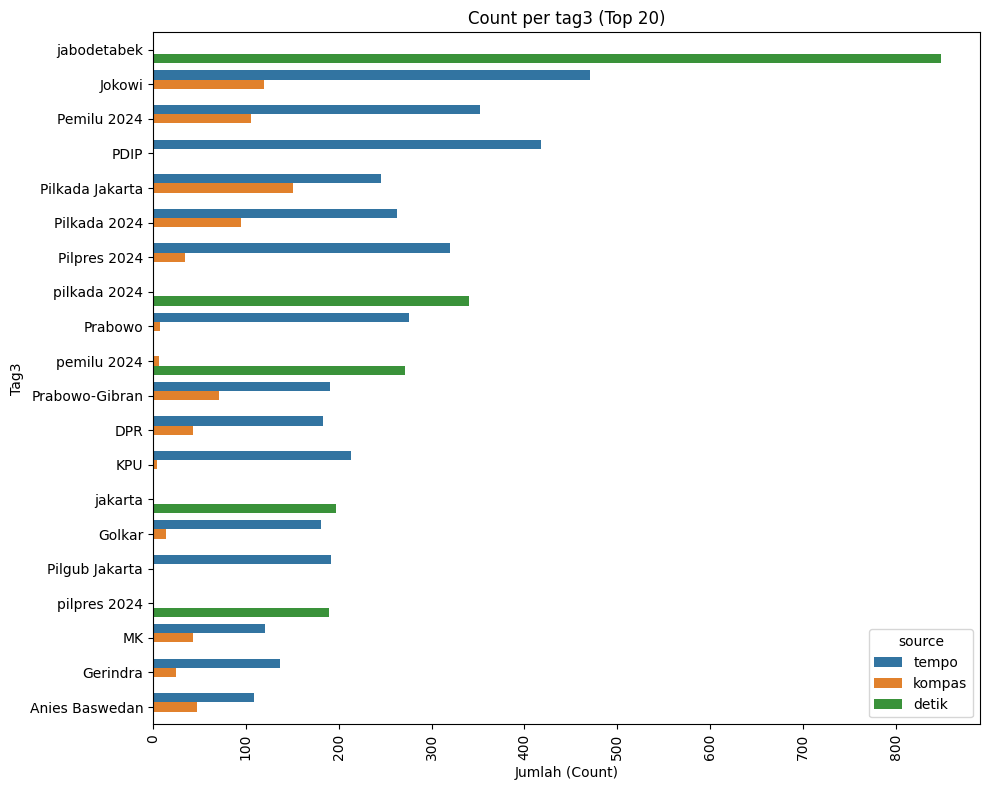

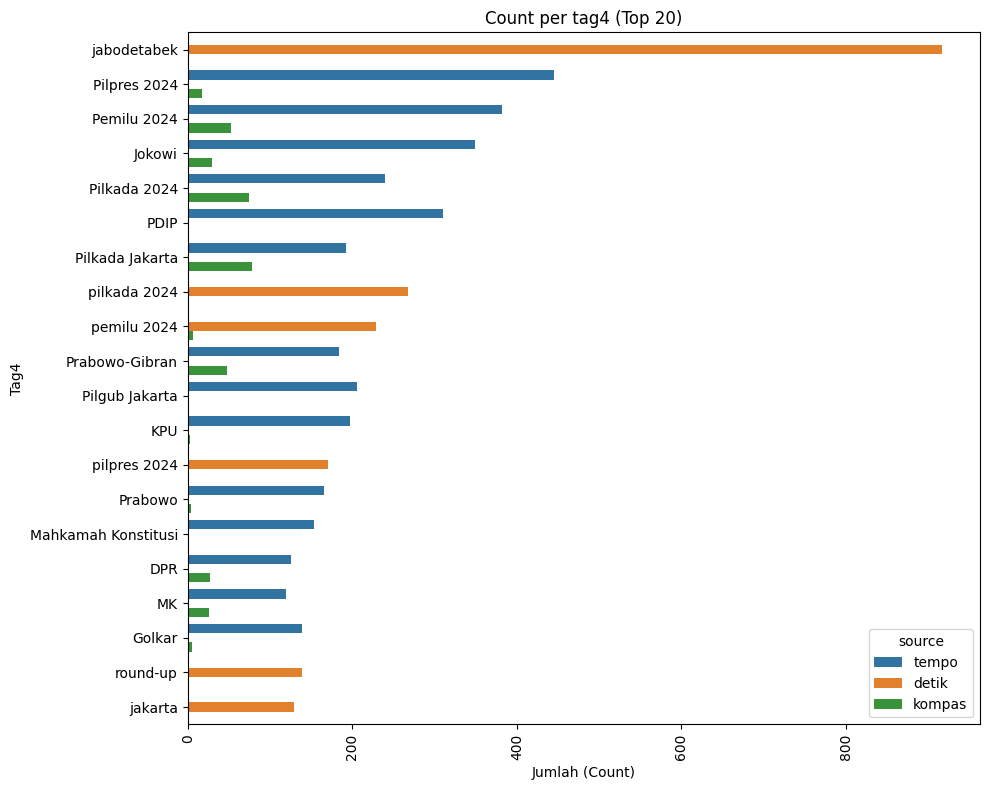

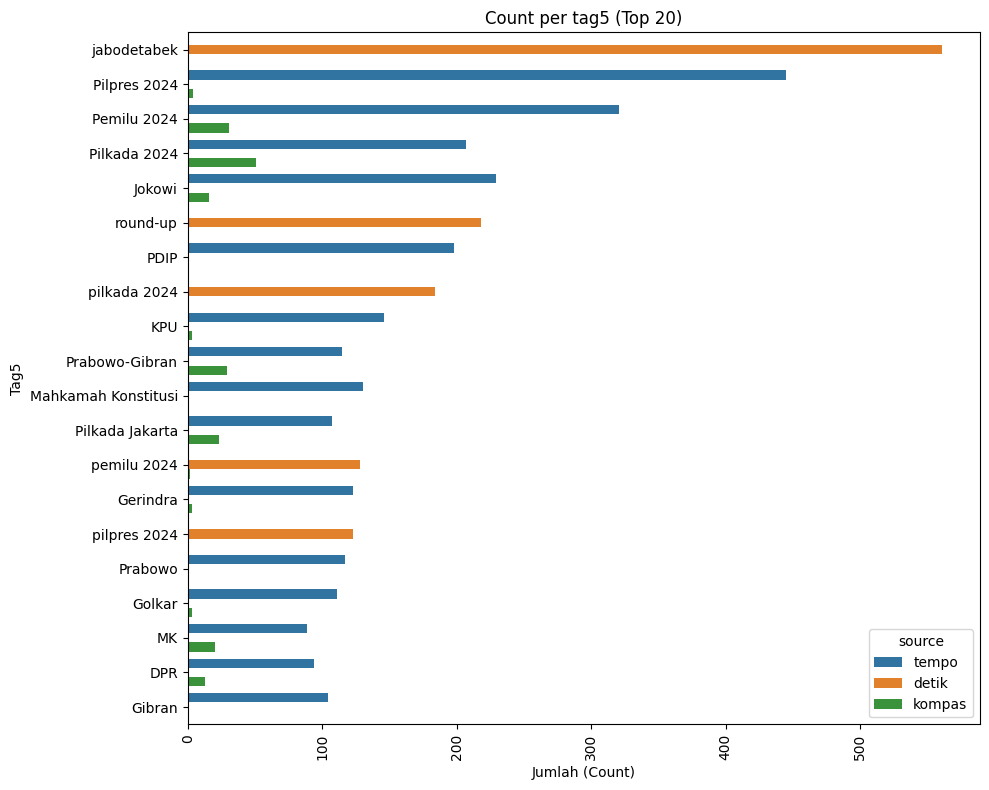

In [67]:
sns.countplot(x='source', data=df)
plt.title("Distribusi class Media Berita")
plt.xlabel("Class Label")
plt.ylabel("Class Counts")
plt.show()

tag_columns = ['tag1', 'tag2', 'tag3', 'tag4', 'tag5']

for tag in tag_columns:
    top_tags = df[tag].value_counts().nlargest(20).index
    df_top = df[df[tag].isin(top_tags)]

    plt.figure(figsize=(10, 8))
    sns.countplot(y=tag, hue='source', data=df_top, order=top_tags)
    plt.xticks(rotation=90)
    plt.title(f"Count per {tag} (Top 20)")
    plt.xlabel("Jumlah (Count)")
    plt.ylabel(tag.capitalize())
    plt.tight_layout()
    plt.show()

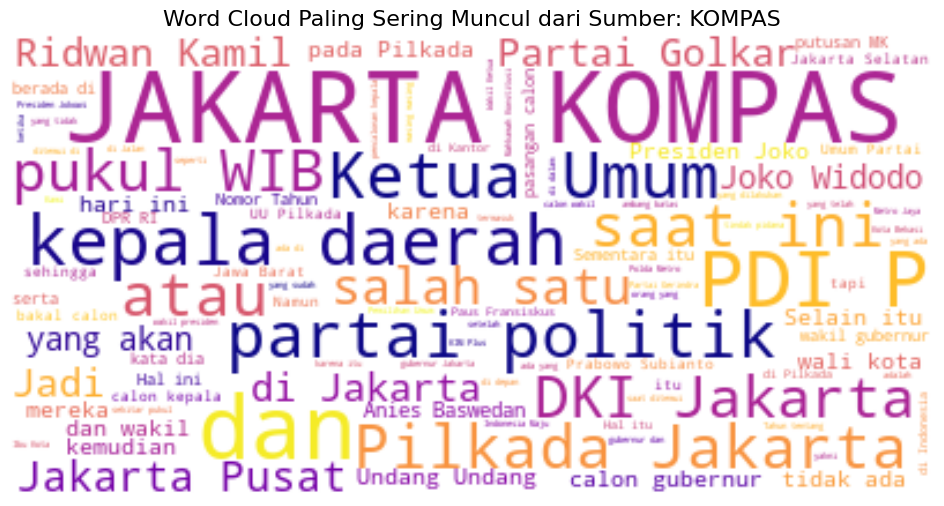

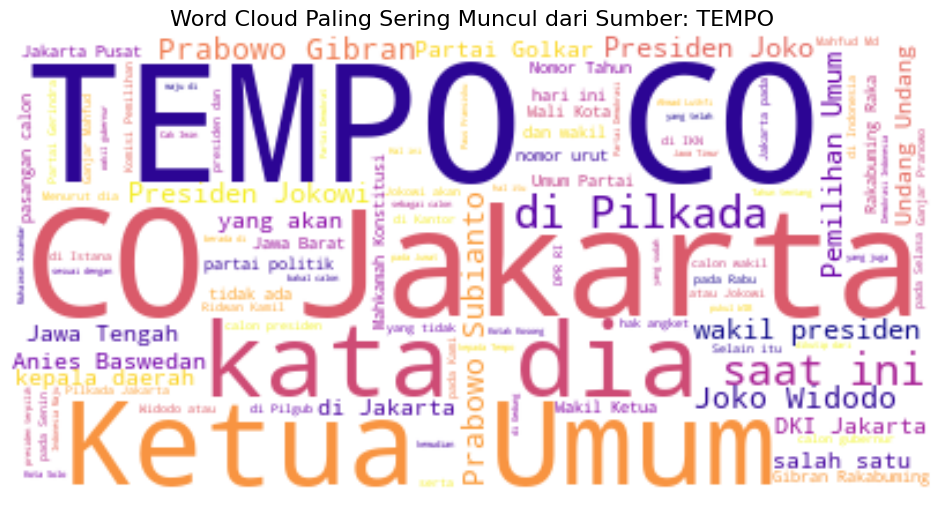

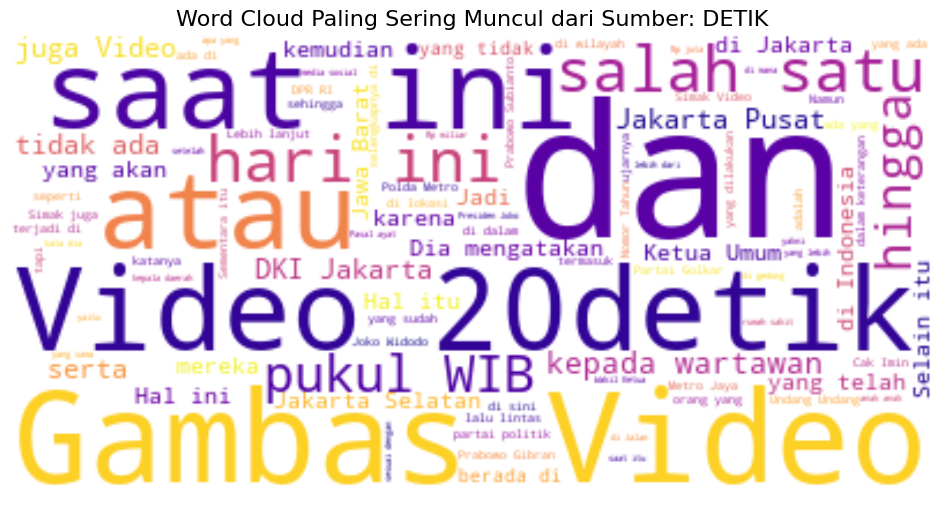

In [33]:
df.dropna(subset=['Content', 'source'], inplace=True)
unique_sources = df['source'].unique()

for source_name in unique_sources:
    df_source_filtered = df[df['source'] == source_name]
    text_for_cloud = " ".join(str(content) for content in df_source_filtered.Content)

    if not text_for_cloud.strip():
        print(f"Tidak ada teks untuk diproses untuk source: {source_name}")
        continue

    wordcloud = WordCloud(max_words=100, colormap='plasma', background_color="white").generate(text_for_cloud)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud Paling Sering Muncul dari Sumber: {source_name.upper()}", size=16)
    plt.show()

### Pengurangan total dataset -> Dataset Downsample: df_dowsample, Dataset tanpa ada duplicate dan none -> data: df_clean



In [34]:
df_dowsample = df.groupby('source').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)
df_dowsample.head()

,Judul,Waktu,Link,Content,tag1,tag2,tag3,tag4,tag5,source
0,"Serunya Festival LIKE 2 Malam Ini, Semua Bergo...","Jumat, 09 Agu 2024 21:52 WIB",https://news.detik.com/berita/d-7482433/seruny...,Festival LIKE 2 dimeriahkan penampilan dari pe...,festivallike,festivallike2,lingkungan,iklim,klhk,detik
1,"Bawaslu Temukan Ada 80 Ribu Pemilih di 1 TPS, ...","Kamis, 15 Feb 2024 21:02 WIB",https://news.detik.com/pemilu/d-7195876/bawasl...,Badan Pengawas Pemilu (Bawaslu) RI menemukan k...,tps,sirekap,sirekap 2024,bawaslu ri,NaN,detik
2,Ibu Tamara Tyasmara Sebut Yudha Arfandi Sempat...,"Senin, 19 Feb 2024 21:48 WIB",https://news.detik.com/berita/d-7201581/ibu-ta...,"Ibu dari Tamara Tyasmara, Ristia Aryuni, berce...",yudha arfandi,tamara tyasmara,dante anak tamara tyasmara,NaN,NaN,detik
3,Cak Imin Kritik LPDP: Yang Miskin dan Pesantre...,"Rabu, 31 Jan 2024 23:57 WIB",https://news.detik.com/pemilu/d-7170822/cak-im...,"Cawapres nomor urut 1, Muhaimin Iskandar atau ...",lpdp,muhaimin iskandar,cak imin,beasiswa lpdp,NaN,detik
4,"Ke Gudang Bulog di Banten, Jokowi Cek Stok Ber...","Senin, 08 Jan 2024 20:57 WIB",https://news.detik.com/berita/d-7131368/ke-gud...,Presiden Joko Widodo (Jokowi) mengecek cadanga...,jokowi,beras,NaN,NaN,NaN,detik


In [35]:
df_dowsample['source'].value_counts()

source
detik     10000
kompas    10000
tempo     10000
Name: count, dtype: int64

In [36]:
name = 'politik_merge_downsample.csv'
try:
  df_dowsample.to_csv('politik_merge_downsample.csv', index=False)
  print(f'File {name} berhasil disimpan')
except:
  print(f'Gagal menyimpan file {name}')

File politik_merge_downsample.csv berhasil disimpan


In [37]:
#Cek data duplikat lewat link berita
print('Data Duplikat:',df_dowsample['Link'].duplicated().any())
print('Total:', df_dowsample['Link'].duplicated().sum(),'\n')

#Cek data kosong
print('Data Kosong:',df_dowsample[['Content', 'Judul']].isnull().values.any())
print('Total:\n',df_dowsample[['Content', 'Judul']].isnull().sum())

Data Duplikat: True
Total: 244 

Data Kosong: False
Total:
 Content    0
Judul      0
dtype: int64


In [38]:
#df_clean_duplicate_none
df_clean = df_dowsample.drop_duplicates(subset=['Link']).dropna(subset=['Content', 'Judul'])

#Cek data duplikat lewat link berita
print('Data Duplikat:',df_clean['Link'].duplicated().any())
print('Total:', df_clean['Link'].duplicated().sum(),'\n')

#Cek data kosong
print('Data Kosong:',df_clean[['Content', 'Judul']].isnull().values.any())
print('Total:\n',df_clean[['Content', 'Judul']].isnull().sum())

Data Duplikat: False
Total: 0 

Data Kosong: False
Total:
 Content    0
Judul      0
dtype: int64


### Pre-Processing, 2 Jam lama, langsung skip aja pakai dataset baru yg udah di download

In [ ]:
Stemmer  = StemmerFactory().create_stemmer()
Stopword = StopWordRemoverFactory().create_stop_word_remover()

def pre_processing (text):
  text = text.lower()
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = Stopword.remove(text)
  text = Stemmer.stem(text)
  return text

df_clean['Content_After'] = df_clean['Content'].swifter.apply(pre_processing)
df_clean['Judul_After'] = df_clean['Judul'].swifter.apply(pre_processing)

Pandas Apply:   0%|          | 0/29756 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/29756 [00:00<?, ?it/s]

In [ ]:
df_clean['All_Tags'] = df_clean[['tag1', 'tag2', 'tag3', 'tag4', 'tag5']].apply(lambda x: [tag for tag in x if pd.notna(tag)], axis=1)

In [ ]:
df_clean.head()

,Judul,Waktu,Link,Content,tag1,tag2,tag3,tag4,tag5,source,Content_After,Judul_After,All_Tags
0,"Serunya Festival LIKE 2 Malam Ini, Semua Bergo...","Jumat, 09 Agu 2024 21:52 WIB",https://news.detik.com/berita/d-7482433/seruny...,Festival LIKE 2 dimeriahkan penampilan dari pe...,festivallike,festivallike2,lingkungan,iklim,klhk,detik,festival like riah tampil nyanyi happy asmara ...,seru festival like malam semua goyang lagu run...,"[festivallike, festivallike2, lingkungan, ikli..."
1,Paloh Tegaskan Komitmen NasDem Dukung Jokowi h...,"Minggu, 25 Agu 2024 20:02 WIB",https://news.detik.com/pemilu/d-7508086/paloh-...,Ketua Umum Partai NasDem Surya Paloh menekanka...,surya paloh,jokowi,nasdem,politik,NaN,detik,ketua umum partai nasdem surya paloh tekan kom...,paloh tegas komitmen nasdem dukung jokowi hing...,"[surya paloh, jokowi, nasdem, politik]"
2,Dubes LN Kagum Lihat Persemaian Mentawir: Inis...,"Selasa, 04 Jun 2024 22:37 WIB",https://news.detik.com/berita/d-7374452/dubes-...,Presiden Joko Widodo (Jokowi) mengajak sejumla...,presiden jokowi,jokowi,duta besar,persemaian mentawir,NaN,detik,presiden joko widodo jokowi ajak jumlah duta b...,dubes ln kagum lihat semai mentawir inisiatif ...,"[presiden jokowi, jokowi, duta besar, persemai..."
3,"Diteriaki 'Maling', Jambret Ponsel Pelari di C...","Senin, 17 Jun 2024 14:34 WIB",https://news.detik.com/berita/d-7395089/diteri...,Viral di media sosial aksi jambret ponsel saat...,jakarta,jabodetabek,viral,jambret,cfd,detik,viral media sosial aksi jambret ponsel car fre...,riak maling jambret ponsel lari cfd sempat nge...,"[jakarta, jabodetabek, viral, jambret, cfd]"
4,"Andre Rosiade: Usung Mahyeldi-Vasko, Gerindra ...","Sabtu, 24 Agu 2024 20:46 WIB",https://news.detik.com/berita/d-7506987/andre-...,Gerindra resmi mengusung Mahyeldi dan Vasko Ru...,gerindra,sumatera barat,NaN,NaN,NaN,detik,gerindra resmi usung mahyeldi vasko ruseimy pi...,andre rosiade usung mahyeldivasko gerindra yak...,"[gerindra, sumatera barat]"


In [ ]:
df_clean.to_csv('C:/Users/user/Downloads/politik_clean.csv', index=False)

### Pre-processing kecil buat kolom tag di df_clean, Skip saja

In [73]:
df_clean = pd.read_csv('C:/Users/user/Downloads/politik_clean.csv')

In [74]:
tag_columns = ['tag1', 'tag2', 'tag3', 'tag4', 'tag5']

def clean_tag(tag):
    if pd.isna(tag):
        return tag
    tag = tag.lower()
    tag = re.sub(r"[\-\_\+\=\[\]\{\}\\\|\;\:\"\'\,\.\<\>\`\~\!\@\#\$\%\^\&\*\(\)]", "", tag)
    tag = tag.replace(" ", "")
    return tag

for col in tag_columns:
    df_clean[col] = df_clean[col].apply(clean_tag)

if 'All_Tags' in df_clean.columns:
    df_clean = df_clean.drop(columns=['All_Tags'])

df_clean['All_Tags'] = df_clean[tag_columns].apply(lambda x: [tag for tag in x if pd.notna(tag)], axis=1)

In [75]:
df_clean.to_csv('C:/Users/user/Downloads/politik_clean.csv', index=False)

### Training Testing Model Machine Learning

In [78]:
df_clean = pd.read_csv('C:/Users/user/Downloads/politik_clean.csv')
df_clean.head()

,Judul,Waktu,Link,Content,tag1,tag2,tag3,tag4,tag5,source,Content_After,Judul_After,All_Tags
0,"Serunya Festival LIKE 2 Malam Ini, Semua Bergo...","Jumat, 09 Agu 2024 21:52 WIB",https://news.detik.com/berita/d-7482433/seruny...,Festival LIKE 2 dimeriahkan penampilan dari pe...,festivallike,festivallike2,lingkungan,iklim,klhk,detik,festival like riah tampil nyanyi happy asmara ...,seru festival like malam semua goyang lagu run...,"['festivallike', 'festivallike2', 'lingkungan'..."
1,Paloh Tegaskan Komitmen NasDem Dukung Jokowi h...,"Minggu, 25 Agu 2024 20:02 WIB",https://news.detik.com/pemilu/d-7508086/paloh-...,Ketua Umum Partai NasDem Surya Paloh menekanka...,suryapaloh,jokowi,nasdem,politik,NaN,detik,ketua umum partai nasdem surya paloh tekan kom...,paloh tegas komitmen nasdem dukung jokowi hing...,"['suryapaloh', 'jokowi', 'nasdem', 'politik']"
2,Dubes LN Kagum Lihat Persemaian Mentawir: Inis...,"Selasa, 04 Jun 2024 22:37 WIB",https://news.detik.com/berita/d-7374452/dubes-...,Presiden Joko Widodo (Jokowi) mengajak sejumla...,presidenjokowi,jokowi,dutabesar,persemaianmentawir,NaN,detik,presiden joko widodo jokowi ajak jumlah duta b...,dubes ln kagum lihat semai mentawir inisiatif ...,"['presidenjokowi', 'jokowi', 'dutabesar', 'per..."
3,"Diteriaki 'Maling', Jambret Ponsel Pelari di C...","Senin, 17 Jun 2024 14:34 WIB",https://news.detik.com/berita/d-7395089/diteri...,Viral di media sosial aksi jambret ponsel saat...,jakarta,jabodetabek,viral,jambret,cfd,detik,viral media sosial aksi jambret ponsel car fre...,riak maling jambret ponsel lari cfd sempat nge...,"['jakarta', 'jabodetabek', 'viral', 'jambret',..."
4,"Andre Rosiade: Usung Mahyeldi-Vasko, Gerindra ...","Sabtu, 24 Agu 2024 20:46 WIB",https://news.detik.com/berita/d-7506987/andre-...,Gerindra resmi mengusung Mahyeldi dan Vasko Ru...,gerindra,sumaterabarat,NaN,NaN,NaN,detik,gerindra resmi usung mahyeldi vasko ruseimy pi...,andre rosiade usung mahyeldivasko gerindra yak...,"['gerindra', 'sumaterabarat']"


In [79]:
df_clean[['Judul', 'Judul_After']].head()

,Judul,Judul_After
0,"Serunya Festival LIKE 2 Malam Ini, Semua Bergo...",seru festival like malam semua goyang lagu run...
1,Paloh Tegaskan Komitmen NasDem Dukung Jokowi h...,paloh tegas komitmen nasdem dukung jokowi hing...
2,Dubes LN Kagum Lihat Persemaian Mentawir: Inis...,dubes ln kagum lihat semai mentawir inisiatif ...
3,"Diteriaki 'Maling', Jambret Ponsel Pelari di C...",riak maling jambret ponsel lari cfd sempat nge...
4,"Andre Rosiade: Usung Mahyeldi-Vasko, Gerindra ...",andre rosiade usung mahyeldivasko gerindra yak...


In [80]:
df_clean[['Content', 'Content_After']].head()

,Content,Content_After
0,Festival LIKE 2 dimeriahkan penampilan dari pe...,festival like riah tampil nyanyi happy asmara ...
1,Ketua Umum Partai NasDem Surya Paloh menekanka...,ketua umum partai nasdem surya paloh tekan kom...
2,Presiden Joko Widodo (Jokowi) mengajak sejumla...,presiden joko widodo jokowi ajak jumlah duta b...
3,Viral di media sosial aksi jambret ponsel saat...,viral media sosial aksi jambret ponsel car fre...
4,Gerindra resmi mengusung Mahyeldi dan Vasko Ru...,gerindra resmi usung mahyeldi vasko ruseimy pi...


In [84]:
value_counts = df_clean['source'].value_counts()
print(value_counts)

source
tempo     9999
detik     9912
kompas    9845
Name: count, dtype: int64


In [83]:
tag_columns = df_clean[['tag1', 'tag2', 'tag3', 'tag4', 'tag5']]
N = 15
print("=== Menampilkan Top ",N,"Tag Paling Sering Muncul per Kolom===\n")

for column_name in tag_columns:
    print(f"--- Top {N} untuk kolom: {column_name} ---")
    top_n_tags = df_clean[column_name].dropna().value_counts().head(N)
    print(top_n_tags)
    print("-" * 30)

=== Menampilkan Top  15 Tag Paling Sering Muncul per Kolom===

--- Top 15 untuk kolom: tag1 ---
tag1
jokowi             1203
prabowo             624
pdip                606
aniesbaswedan       498
kpk                 463
kpu                 434
pkb                 377
ridwankamil         353
anies               295
golkar              265
prabowosubianto     259
pks                 254
pausfransiskus      242
gibran              232
mahfudmd            196
Name: count, dtype: int64
------------------------------
--- Top 15 untuk kolom: tag2 ---
tag2
jokowi             710
pdip               409
pilkada2024        357
aniesbaswedan      356
prabowo            355
jabodetabek        334
pemilu2024         324
pilkadajakarta     322
golkar             254
kpu                219
ikn                208
prabowosubianto    194
pilpres2024        180
pkb                179
mk                 176
Name: count, dtype: int64
------------------------------
--- Top 15 untuk kolom: tag3 ---
tag3
jabo

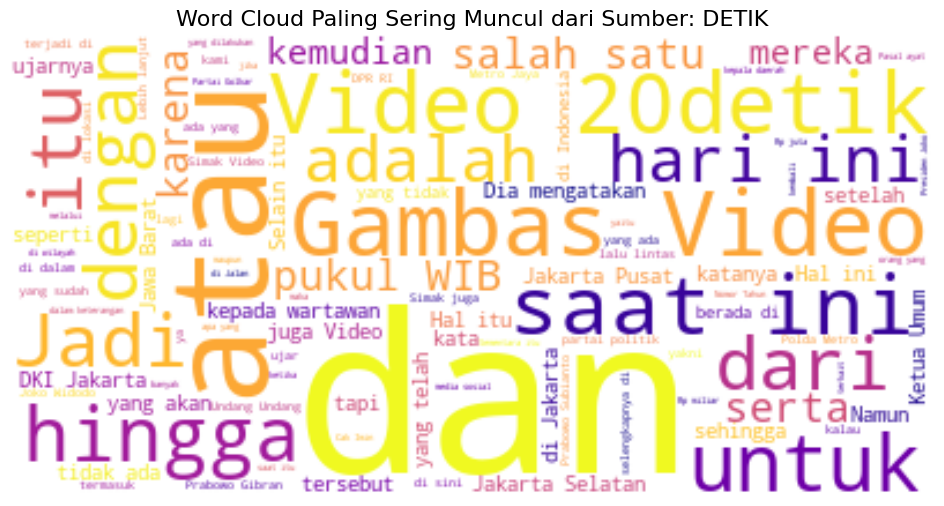

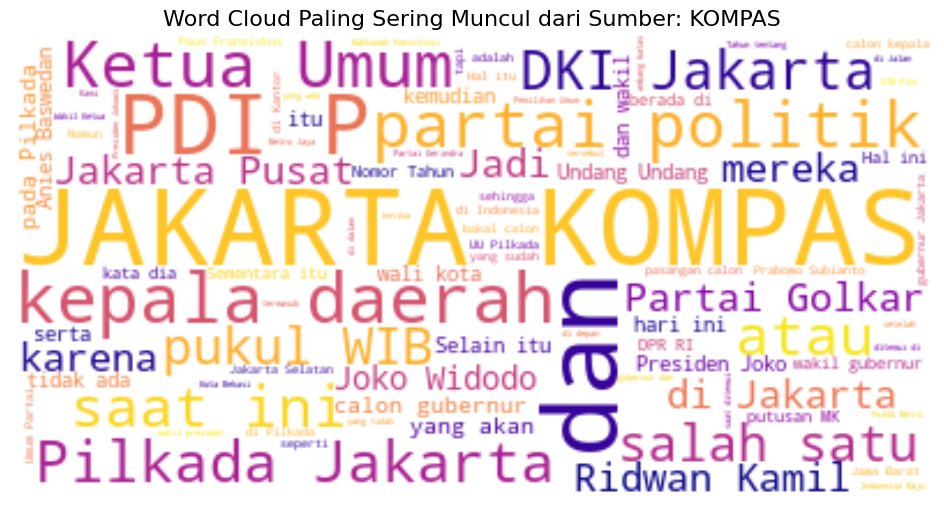

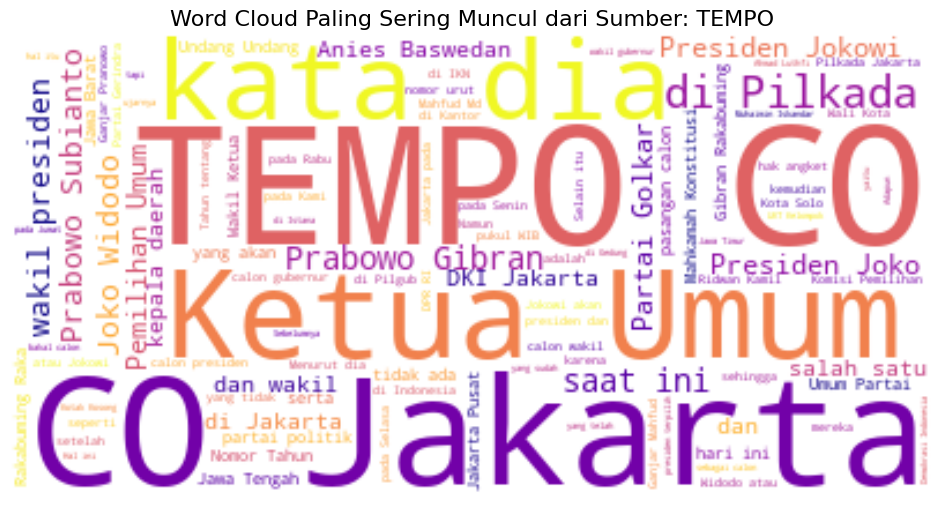

In [81]:
df_clean.dropna(subset=['Content_After', 'source'], inplace=True)
unique_sources = df_clean['source'].unique()

for source_name in unique_sources:
    df_source_filtered = df_clean[df_clean['source'] == source_name]
    text_for_cloud = " ".join(str(content) for content in df_source_filtered.Content)

    if not text_for_cloud.strip():
        print(f"Tidak ada teks untuk diproses untuk source: {source_name}")
        continue

    wordcloud = WordCloud(max_words=100, colormap='plasma', background_color="white").generate(text_for_cloud)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud Paling Sering Muncul dari Sumber: {source_name.upper()}", size=16)
    plt.show()

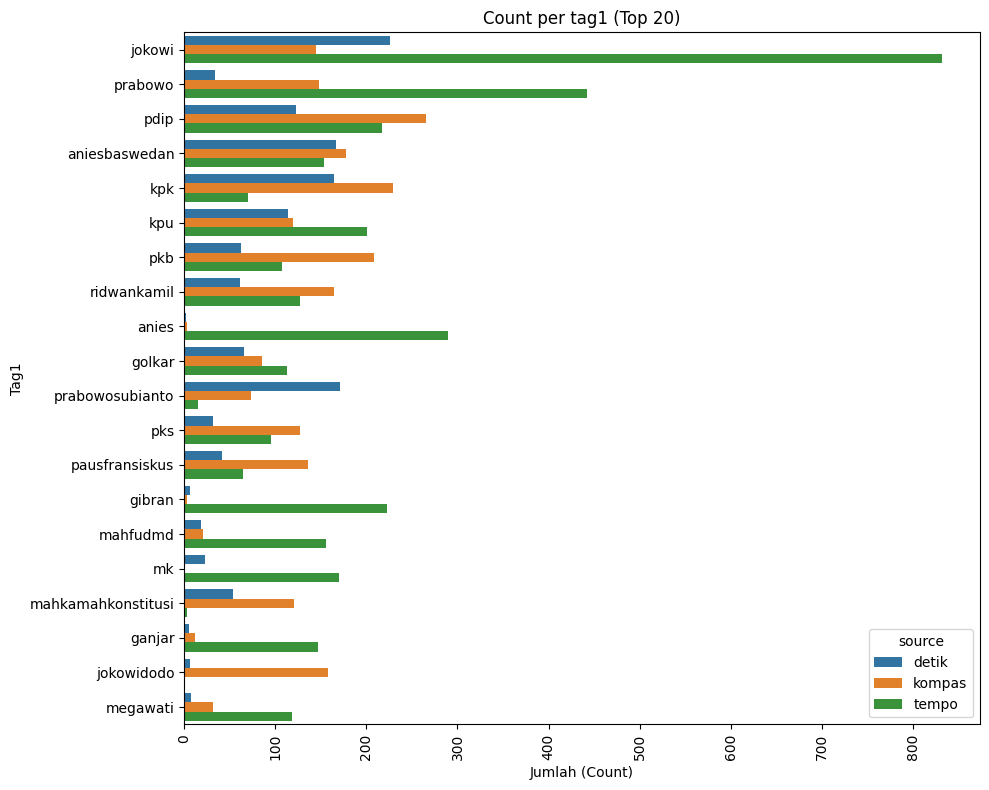

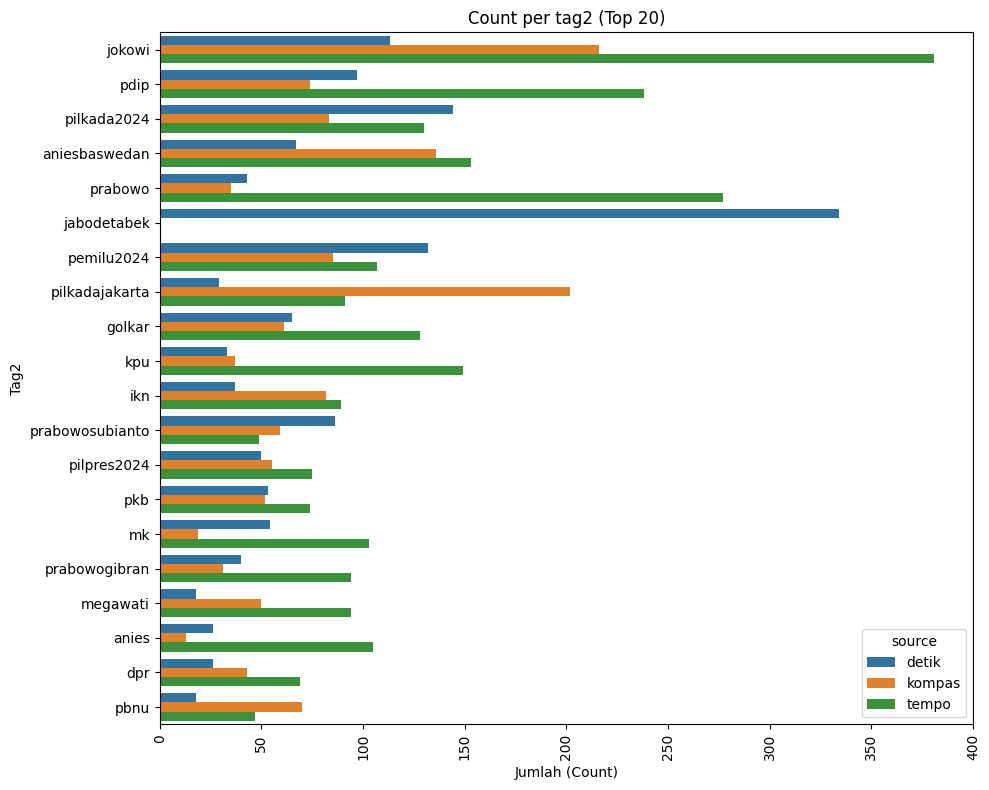

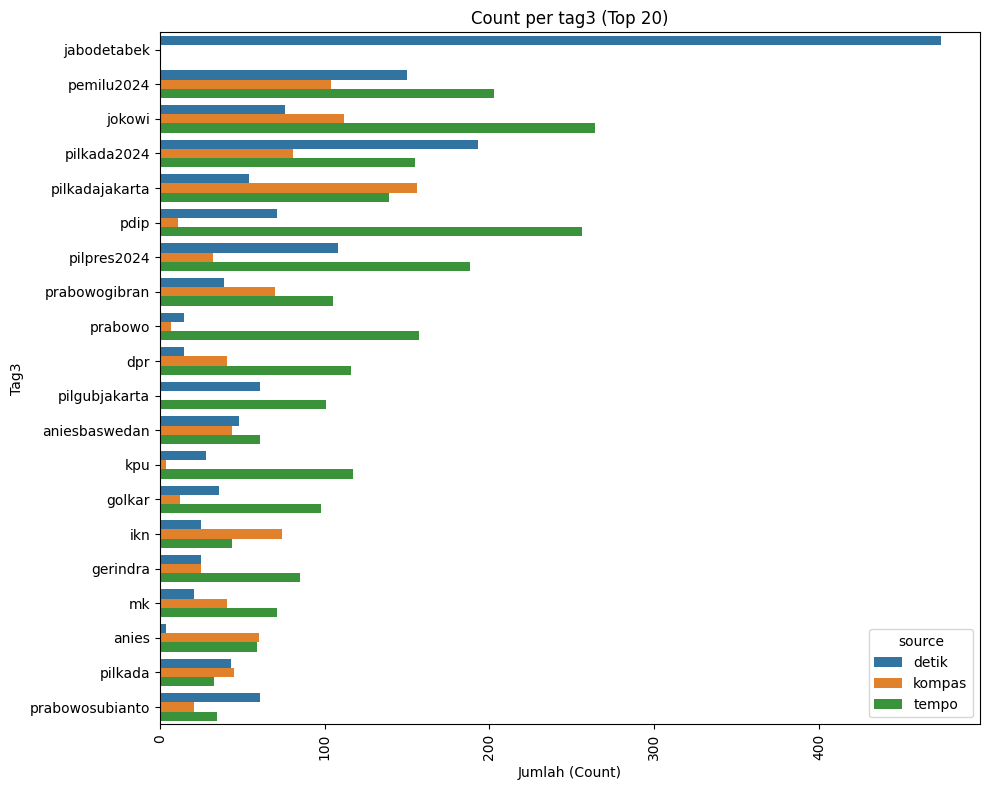

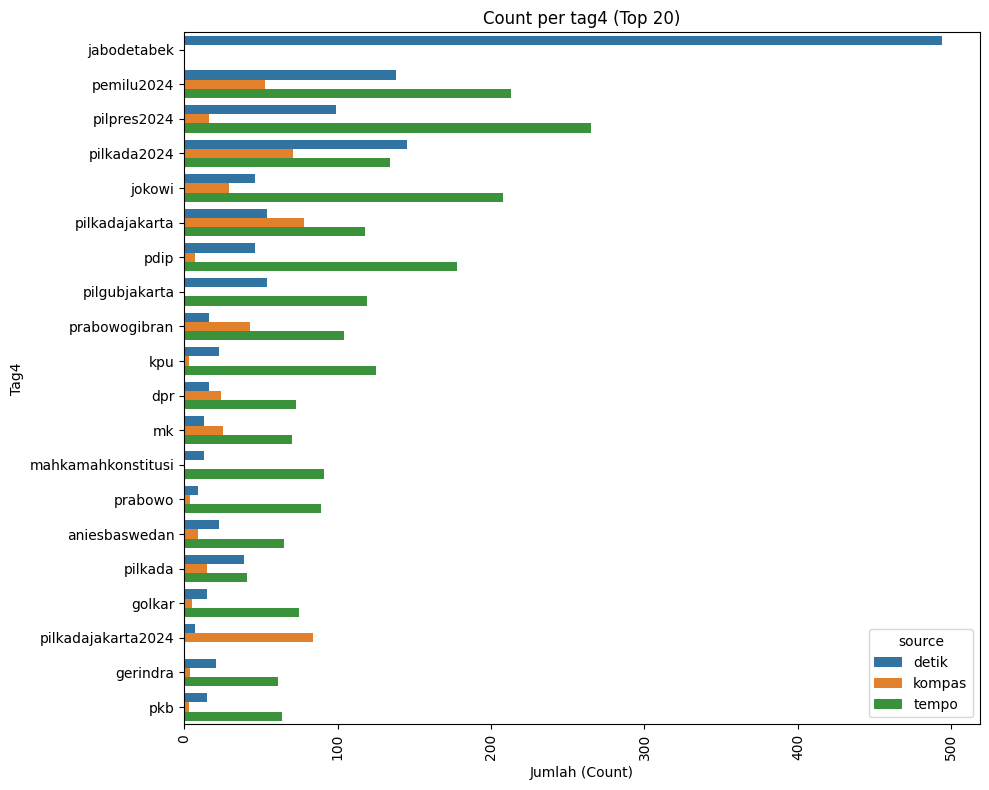

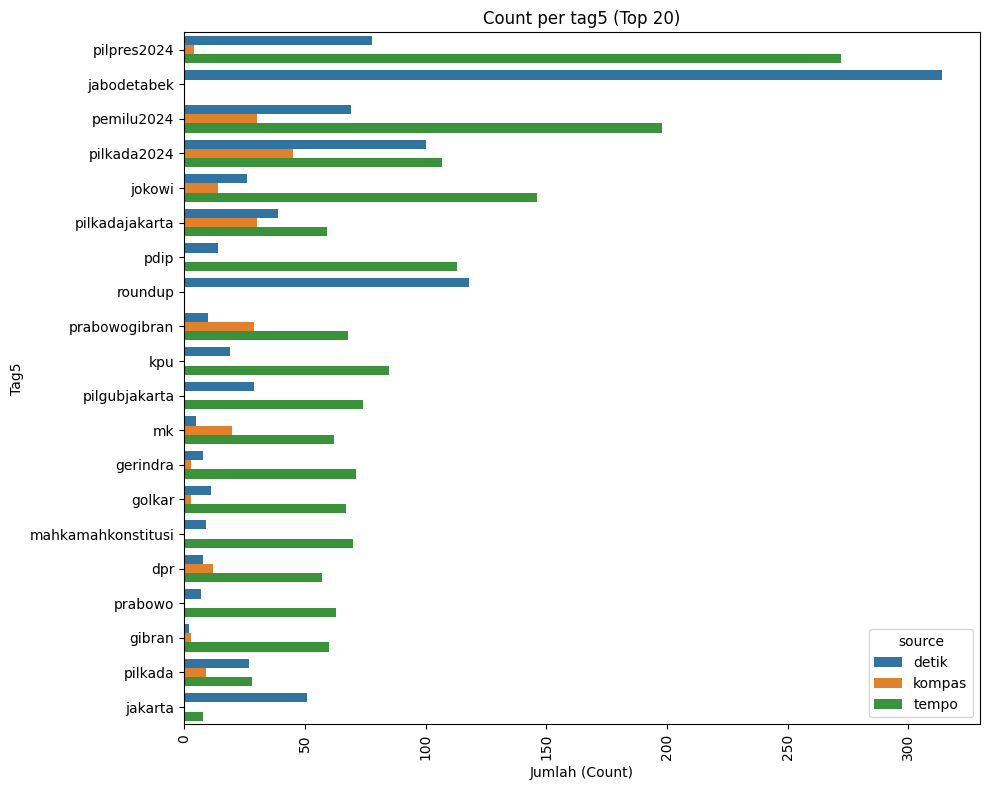

In [82]:
tag_columns = ['tag1', 'tag2', 'tag3', 'tag4', 'tag5']

for tag in tag_columns:
    top_tags = df_clean[tag].value_counts().nlargest(20).index
    df_top = df_clean[df_clean[tag].isin(top_tags)]

    plt.figure(figsize=(10, 8))
    sns.countplot(y=tag, hue='source', data=df_top, order=top_tags)
    plt.xticks(rotation=90)
    plt.title(f"Count per {tag} (Top 20)")
    plt.xlabel("Jumlah (Count)")
    plt.ylabel(tag.capitalize())
    plt.tight_layout()
    plt.show()


==================== EVALUASI MODEL: NAIVEBAYES ====================
Akurasi Training: 72.67%
Akurasi Testing : 70.83%
Waktu Training: 0.0229 detik
Waktu Prediksi: 0.0030 detik

Classification Report:
              precision    recall  f1-score   support

       detik       0.70      0.66      0.68      1983
      kompas       0.76      0.60      0.67      1969
       tempo       0.69      0.86      0.76      2000

    accuracy                           0.71      5952
   macro avg       0.71      0.71      0.70      5952
weighted avg       0.71      0.71      0.70      5952


Accuracy  = 70.83%
Recall    = 70.76%
Precision = 71.37%
F1-Score  = 70.39%


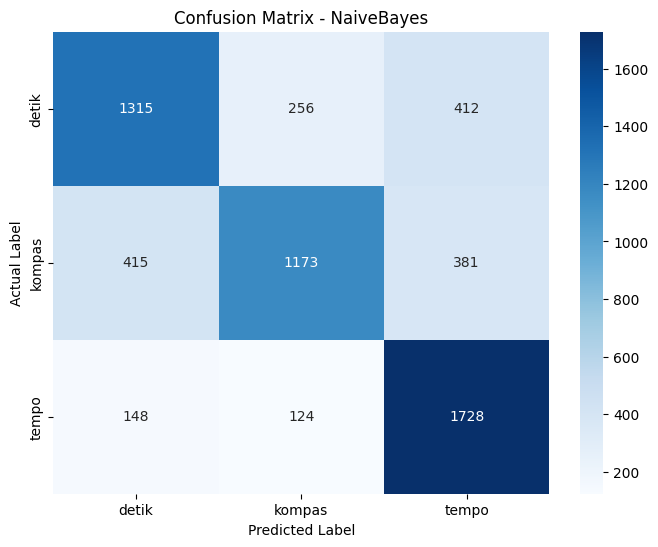


==================== EVALUASI MODEL: LOGISTICREGRESSION ====================
Akurasi Training: 98.13%
Akurasi Testing : 95.72%
Waktu Training: 1.4634 detik
Waktu Prediksi: 0.0020 detik

Classification Report:
              precision    recall  f1-score   support

       detik       0.93      0.96      0.95      1983
      kompas       0.98      0.95      0.96      1969
       tempo       0.97      0.96      0.96      2000

    accuracy                           0.96      5952
   macro avg       0.96      0.96      0.96      5952
weighted avg       0.96      0.96      0.96      5952


Accuracy  = 95.72%
Recall    = 95.71%
Precision = 95.76%
F1-Score  = 95.73%


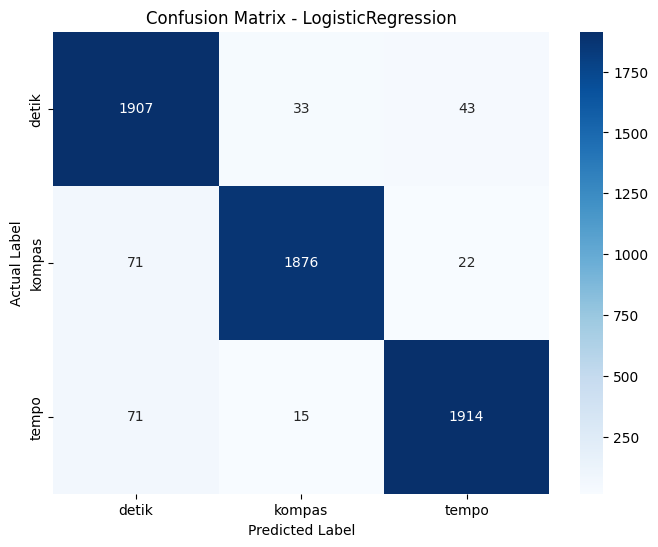


==================== EVALUASI MODEL: RANDOMFOREST ====================
Akurasi Training: 100.00%
Akurasi Testing : 99.38%
Waktu Training: 46.7855 detik
Waktu Prediksi: 0.2614 detik

Classification Report:
              precision    recall  f1-score   support

       detik       0.99      0.99      0.99      1983
      kompas       1.00      0.99      0.99      1969
       tempo       0.99      1.00      1.00      2000

    accuracy                           0.99      5952
   macro avg       0.99      0.99      0.99      5952
weighted avg       0.99      0.99      0.99      5952


Accuracy  = 99.38%
Recall    = 99.38%
Precision = 99.38%
F1-Score  = 99.38%


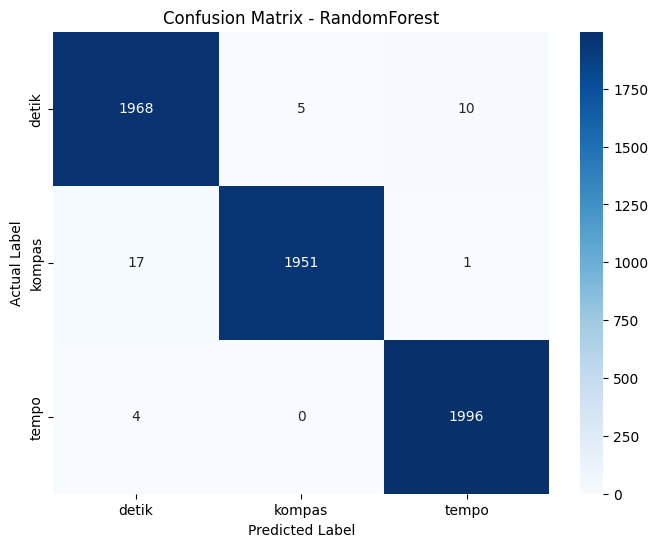


==================== EVALUASI MODEL: SVM ====================
Akurasi Training: 99.76%
Akurasi Testing : 95.65%
Waktu Training: 1366.7569 detik
Waktu Prediksi: 100.0342 detik

Classification Report:
              precision    recall  f1-score   support

       detik       0.93      0.97      0.95      1983
      kompas       0.98      0.95      0.96      1969
       tempo       0.97      0.96      0.96      2000

    accuracy                           0.96      5952
   macro avg       0.96      0.96      0.96      5952
weighted avg       0.96      0.96      0.96      5952


Accuracy  = 95.65%
Recall    = 95.65%
Precision = 95.72%
F1-Score  = 95.66%


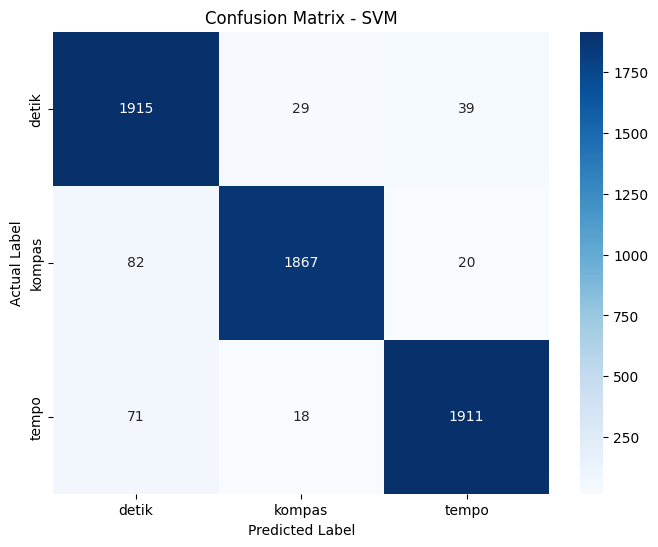

In [62]:
vectorizer = TfidfVectorizer(max_features=5000, min_df=4, max_df=0.85)
X = vectorizer.fit_transform(df_clean['Content_After'])
le = LabelEncoder()
y = le.fit_transform(df_clean['source'])
class_names = le.classes_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
del df_clean
gc.collect()
models = {
    'NaiveBayes': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC()
}
for name, model in models.items():
    print(f"\n{'='*20} EVALUASI MODEL: {name.upper()} {'='*20}")

    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    time_train = t1 - t0

    y_pred = model.predict(X_test)
    t2 = time.time()
    time_predict = t2 - t1

    test_accuracy = model.score(X_test, y_test)
    train_accuracy = model.score(X_train, y_train)

    print(f"Akurasi Training: {train_accuracy*100:.2f}%")
    print(f"Akurasi Testing : {test_accuracy*100:.2f}%")

    print(f"Waktu Training: {time_train:.4f} detik")
    print(f"Waktu Prediksi: {time_predict:.4f} detik")

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    print(f"\nAccuracy  = {accuracy*100:.2f}%")
    print(f"Recall    = {recall*100:.2f}%")
    print(f"Precision = {precision*100:.2f}%")
    print(f"F1-Score  = {f1*100:.2f}%")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

### IndoBert